# Sivers-C

In [1]:
import sys,os
os.chdir('../../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text',usetex=True)
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest

## setup

In [2]:
path='outputs/sivers/sivers-C-world'

In [3]:
ls $path

f.png               nest1               relative-error.png  xf.png
nest0               params_corr.png     sivers-C-world.py


In [4]:
# world
conf=load_config('%s/sivers-C-world.py'%path)
resman=RESMAN(conf);
parman=resman.conf['parman']
Nruns=2
nest=[]
for i in range(0,Nruns):
    nest.append(load('%s/nest%d'%(path,i)))
if len(nest) > 0:
    print
    print nest[0].keys()

loading sidis data sets 2015
['active nll', 'samples', 'logz', 'l', 'weights', 'active p', 'x']


## analyze nested sampling statistics

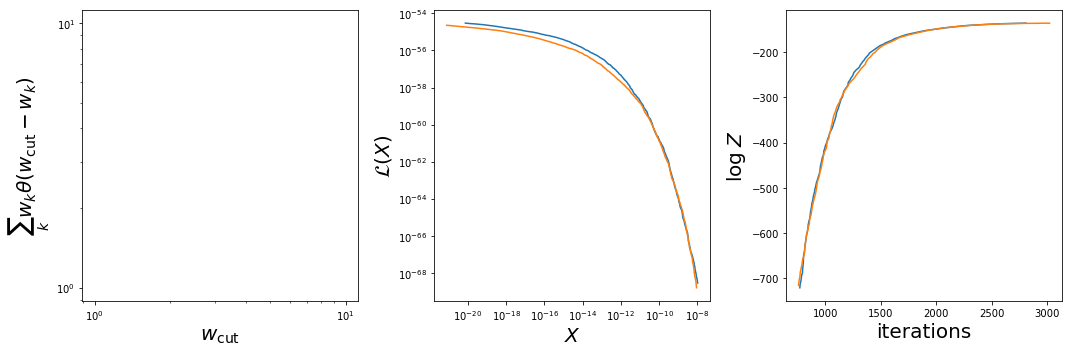

In [5]:
# world
wmin_cut=1e-10
nrows,ncols=1,3
py.figure(figsize=(ncols*5,nrows*5))

ax=py.subplot(nrows,ncols,1)
weights={}
wmin={}
wmax={}
ww={}
for i in range(0,Nruns):
    _wmax=np.amax(nest[i]['weights'])
    weights[i]=np.copy(nest[i]['weights'])
    weights[i]=[w for w in weights[i] if w>wmin_cut]
    wmin[i]=np.amin(weights[i])
    wmax[i]=np.amax(weights[i])
    ww[i]=np.linspace(np.log10(wmin[i]),np.log10(wmax[i]),1000)
wsum=lambda wcut: np.sum([w for w in weights if w<wcut])
for i in range(0,Nruns):
    ax.plot(ww[i],[wsum(wcut) for wcut in ww[i]])
ax.semilogx();
ax.semilogy();
ax.set_ylabel(r'$\sum_k w_k \theta(w_{\rm cut}-w_k)$',size=20)
ax.set_xlabel(r'$w_{\rm cut}$',size=20)

ax=py.subplot(nrows,ncols,2)
X=[]
L=[]
for j in range(0,Nruns):
    X.append([nest[j]['x'][i] for i in range(len(nest[j]['x'])) if nest[j]['weights'][i]>wmin_cut])
    L.append([nest[j]['l'][i] for i in range(len(nest[j]['l'])) if nest[j]['weights'][i]>wmin_cut])
for j in range(0,Nruns):
    ax.plot(X[j],L[j])
ax.semilogx()
ax.semilogy()
ax.set_ylabel(r'${\cal L}(X)$',size=20)
ax.set_xlabel(r'$X$',size=20)

ax=py.subplot(nrows,ncols,3)
it=[]
LOGZ=[]
for j in range(0,Nruns):
    it.append([i for i in range(len(nest[j]['x'])) if nest[j]['weights'][i]>wmin_cut])
    LOGZ.append([nest[j]['logz'][i] for i in range(len(nest[j]['l'])) if nest[j]['weights'][i]>wmin_cut])
for j in range(0,Nruns):
    ax.plot(it[j],LOGZ[j])
ax.set_ylabel(r'$\log \;Z$',size=20)
ax.set_xlabel(r'iterations',size=20)

py.tight_layout()

## remove samples using sum_w cut criterion.  

In [6]:
fnest=[]
samples={}
for i in range(0,Nruns):
    weights[i]=[nest[i]['weights'][j] for j in range(len(nest[i]['weights'])) if nest[i]['weights'][j]>wmin_cut]
    samples[i]=[nest[i]['samples'][j] for j in range(len(nest[i]['weights'])) if nest[i]['weights'][j]>wmin_cut]
    weights[i]/=np.sum(weights[i])
    fnest.append({})
    fnest[i]['weights']=weights[i]
    fnest[i]['samples']=samples[i]
    print 'nes=%d  fnest=%d'%(len(nest[i]['samples']),len(fnest[i]['samples']))

nes=4658  fnest=2812
nes=4884  fnest=3024


## data vs theory

In [9]:
# time consuming: run if is necessary

def get_RAW():
    RAW={}
    for k in conf['datasets']: RAW[k]={}
    for kk in conf['datasets'][k]['xlsx']: RAW[k][kk]=[]
    return RAW
        
samples=fnest['samples']
weights=fnest['weights']

THY=get_RAW()
RES=get_RAW()
bar=BAR('gen chi2 values',len(samples))
for i in range(len(samples)):
    par=samples[i]
    resman.get_residuals(par)
    for k in RES:
        for kk in RES[k]: 
            if k=='sidis': 
                THY[k][kk].append(np.copy(resman.sidisres.tabs[kk]['thy']))
                RES[k][kk].append(np.copy(resman.sidisres.tabs[kk]['residuals']))
    bar.next()
bar.finish()
RAW={'THY':THY,'RES':RES}
save(RAW,'%s/raw'%path)

gen chi2 values [100%]


In [10]:
RAW=load('%s/raw'%path)

In [11]:
RES=RAW['RES']
THY=RAW['THY']

for k in RES:
    for kk in RES[k]: 
        if k=='sidis': 
            thy =np.einsum('k,ki',weights,np.array(THY[k][kk]))
            dthy=np.einsum('k,ki',weights,(np.array(THY[k][kk])-thy)**2)**0.5
            residuals=np.einsum('k,ki',weights,RES[k][kk])
            resman.sidisres.tabs[kk]['thy']=thy
            resman.sidisres.tabs[kk]['dthy']=dthy
            resman.sidisres.tabs[kk]['residuals']=residuals
            resman.sidisres.tabs[kk]['chi2']=residuals**2
            resman.sidisres.tabs[kk]=pd.DataFrame(resman.sidisres.tabs[kk])

## AUT plot

In [13]:
def plot_AUT(K):
    ncols=4
    nrows=len(K)/ncols
    if len(K)%ncols!=0: nrows+=1
    py.figure(figsize=(ncols*4,nrows*2))
    cnt=0
    CHI2=0
    NPTS=0
    for k in K:
        cnt+=1
        d=resman.sidisres.tabs[k]
        chi2=np.sum(d.residuals**2)
        npts=d.residuals.size
        CHI2+=chi2
        NPTS+=npts
        ax=py.subplot(nrows,ncols,cnt)
        dep=d['dependence'].values[0]
        obs=d['obs'].values[0]
        tar=d['target'].values[0]
        had=d['hadron'].values[0]
        if dep=='pt': dep='pT'
        ax.errorbar(d[dep],d['value'],d['alpha'],fmt='k.')
        ax.fill_between(d[dep],d['thy']-d['dthy'],d['thy']+d['dthy'],alpha=0.5)
        ax.plot(d[dep],d['thy'])
        ax.set_xlabel(dep)
        ax.set_ylabel(obs)
        ax.set_title('%s %s chi2=%0.2f  npts=%d'%(tar,had,chi2,npts))
        py.tight_layout()
    print 'CHI2=%0.2f  NPTS=%d'%(CHI2,NPTS)
tabs=resman.sidisres.tabs
K=tabs.keys()

In [15]:
#plot_AUT([k for k in K if k>=2000 if tabs[k]['dependence'].values[0]=='x'])

In [16]:
#plot_AUT([k for k in K if k>=2000 if resman.sidisres.tabs[k]['dependence'].values[0]=='z'])

In [17]:
#plot_AUT([k for k in K if k>=2000 if resman.sidisres.tabs[k]['dependence'].values[0]=='pt'])

## parameters

In [7]:
def plot_params(Nruns,k,kk):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par={}
        mean={}
        std={}
        for j in range(0,Nruns):
            par[j]=np.transpose(samples[j])[get_idx(kk[i])]
            mean[j]=np.einsum('k,k',weights[j],par[j]) 
            std[j]=np.einsum('k,k',weights[j],(np.array(par[j])-mean[j])**2)**0.5 
            #ax.hist(par,histtype='stepfilled',weights=weights,bins=10,facecolor='Yellow',edgecolor='k')
            ax.hist(par[j],histtype='step',weights=weights[j],bins=20)
        pmin=conf['params'][k][kk[i]]['min']
        pmax=conf['params'][k][kk[i]]['max']
        ax.set_xlim(pmin,pmax)
        ax.tick_params(axis='both', which='major', labelsize=14)
        #par=samples[get_idx(kk[i])]
        #ax.hist(par,histtype='stepfilled',weights=nes['weights'],range=(pmin,pmax),bins=10,facecolor='Yellow',edgecolor='k')        ax.hist(par1,histtype='stepfilled',weights=core1.nes['weights'],range=(pmin,pmax),bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_title('%s-%s'%(k,kk[i]))
        #ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    py.tight_layout()

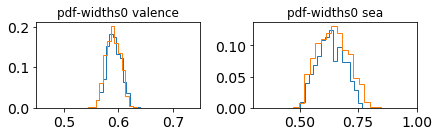

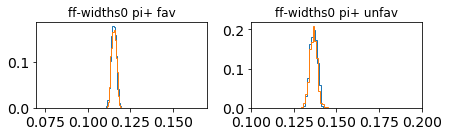

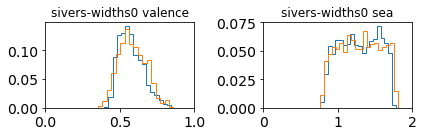

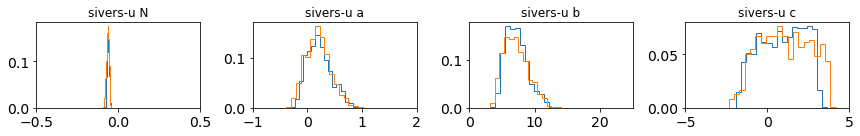

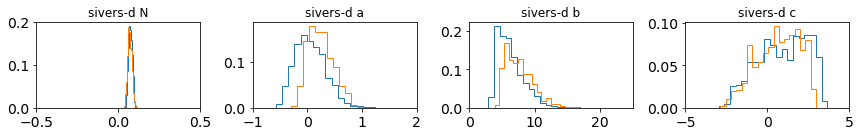

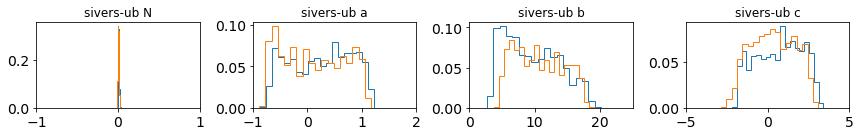

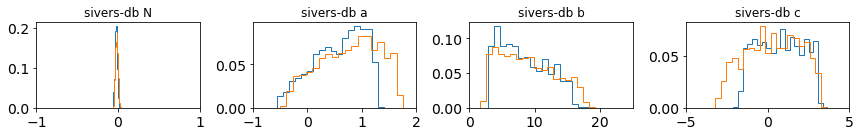

In [8]:
plot_params(Nruns,'pdf',['widths0 valence','widths0 sea'])
plot_params(Nruns,'ff',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params(Nruns,'sivers',['widths0 valence','widths0 sea'])
plot_params(Nruns,'sivers',['u N','u a','u b','u c'])
plot_params(Nruns,'sivers',['d N','d a','d b','d c'])
plot_params(Nruns,'sivers',['ub N','ub a','ub b','ub c'])
plot_params(Nruns,'sivers',['db N','db a','db b','db c'])

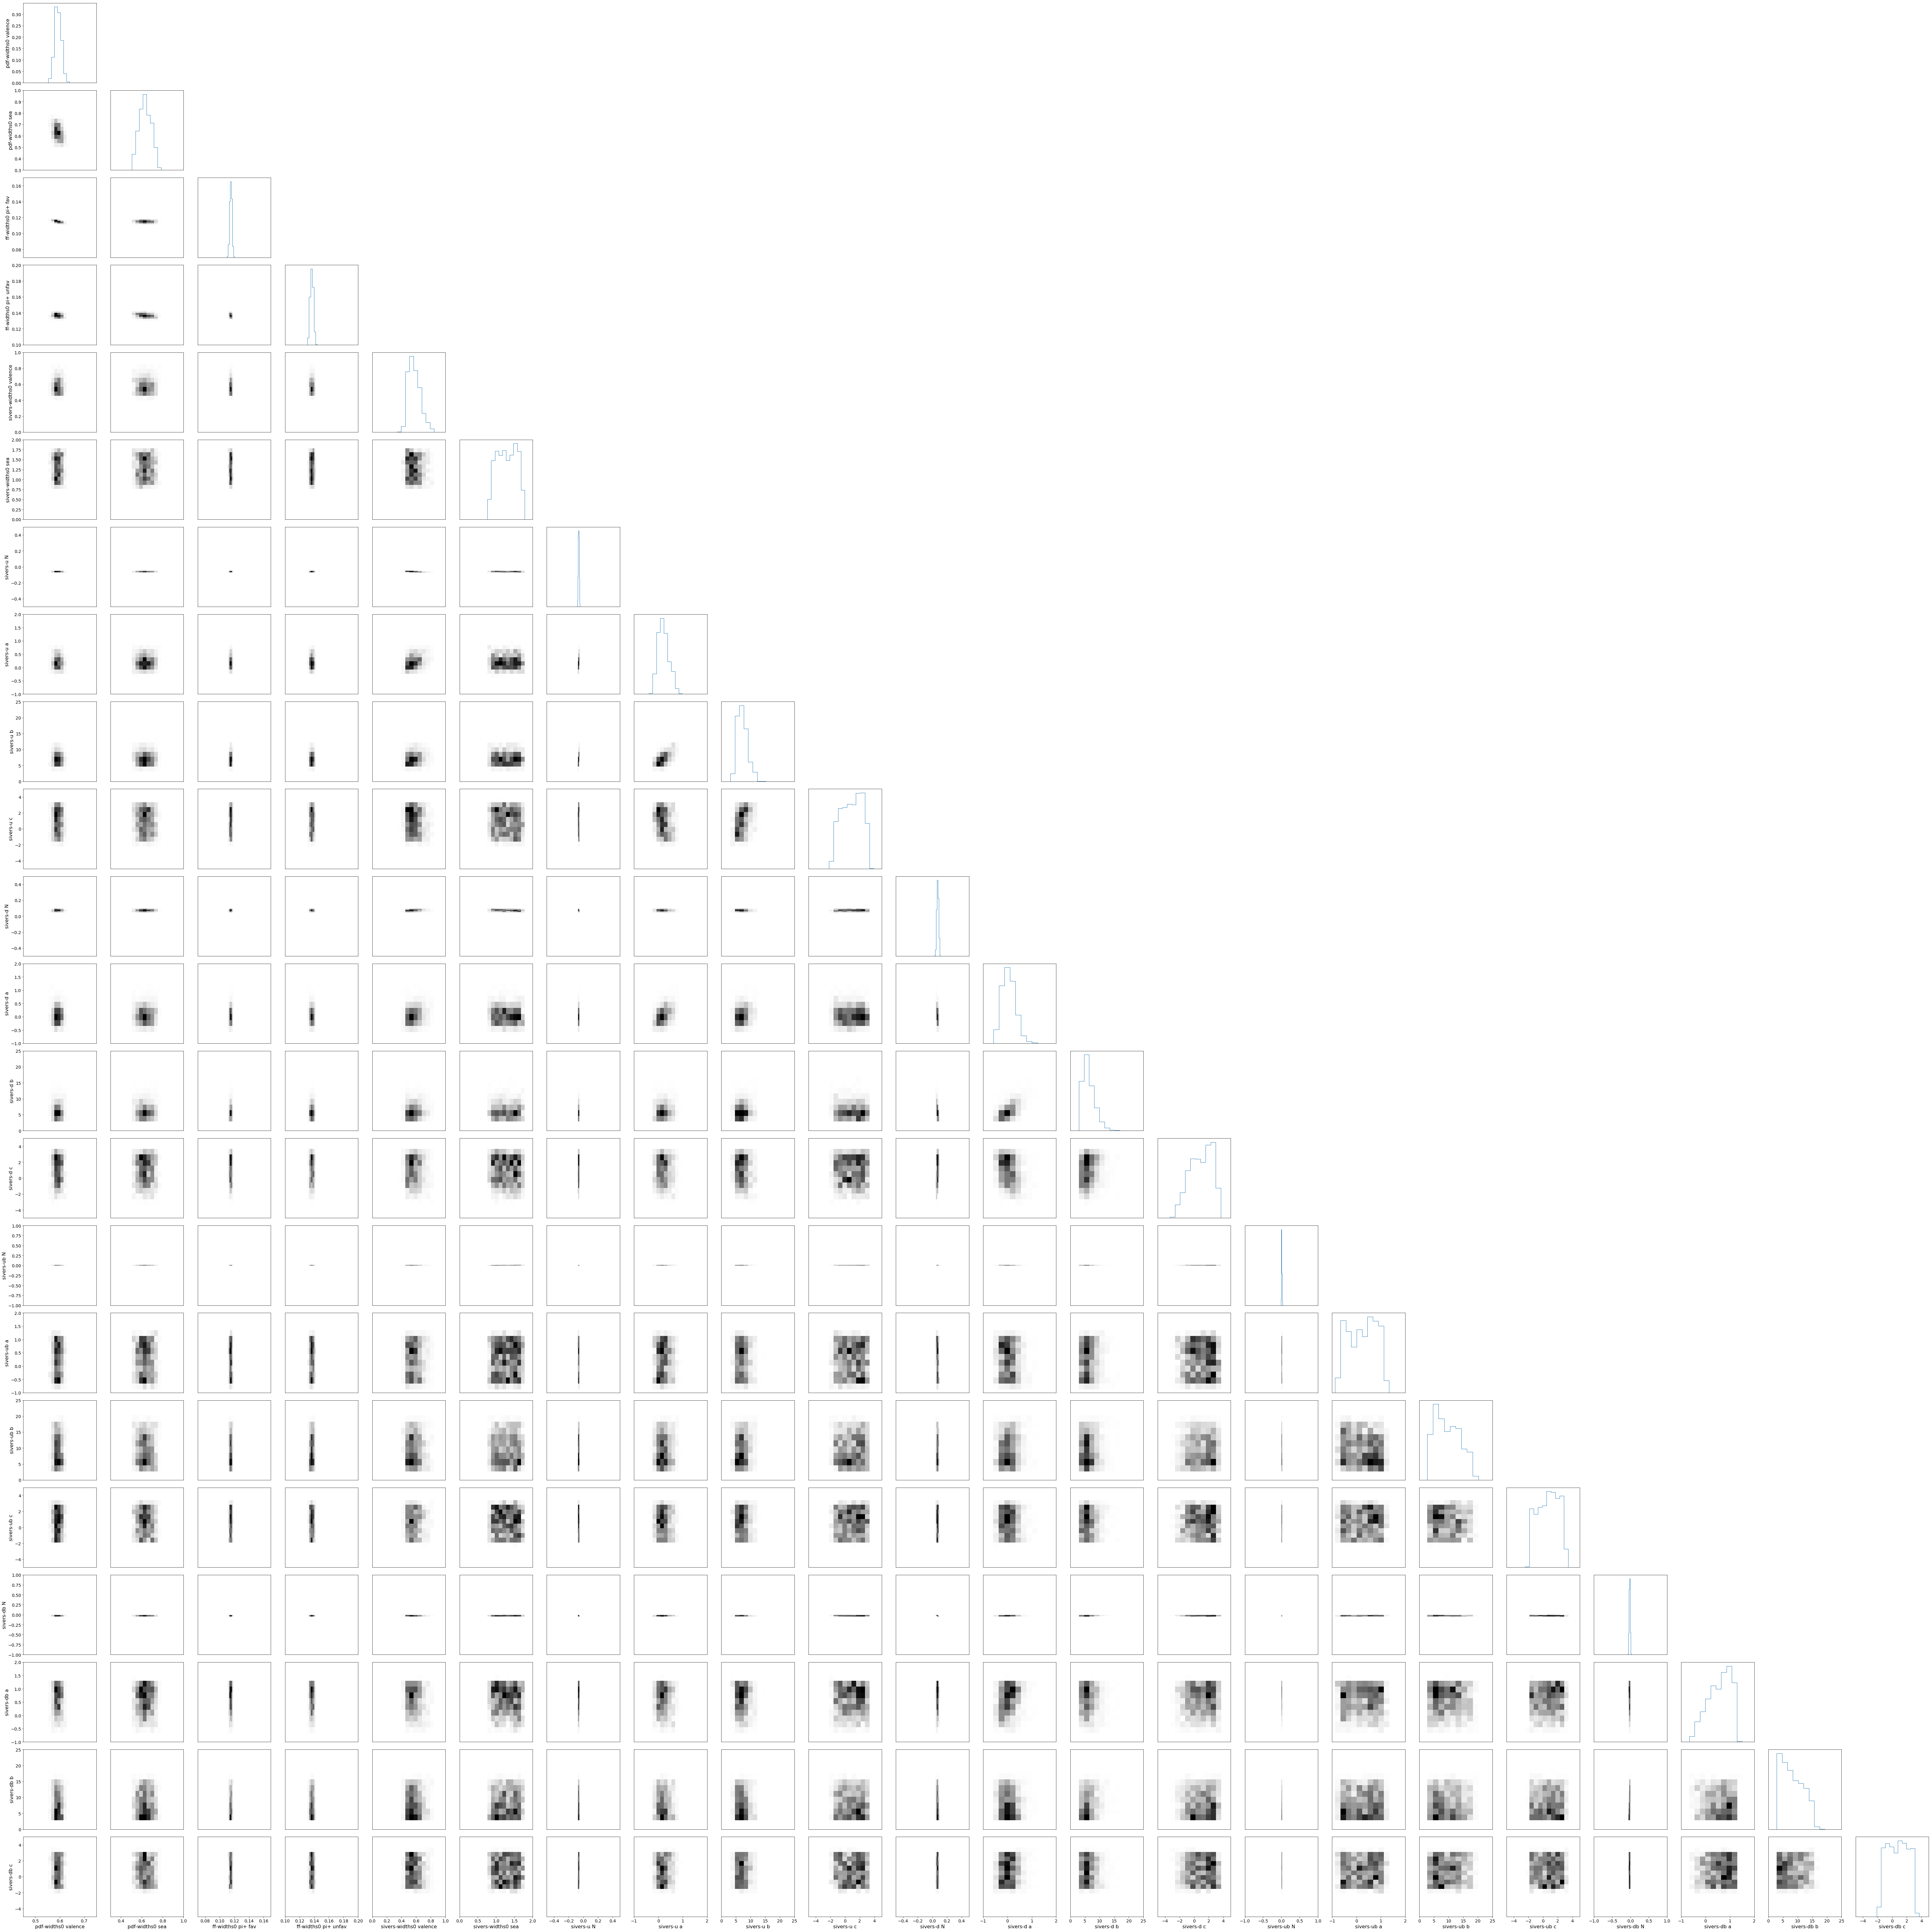

In [45]:
plist=[]
plist.extend([['pdf','widths0 valence'],['pdf','widths0 sea']])
plist.extend([['ff','widths0 pi+ fav'],['ff','widths0 pi+ unfav']])
plist.extend([['sivers','widths0 valence'],['sivers','widths0 sea']])
plist.extend([['sivers','u N'],['sivers','u a'],['sivers','u b'],['sivers','u c']])
plist.extend([['sivers','d N'],['sivers','d a'],['sivers','d b'],['sivers','d c']])
plist.extend([['sivers','ub N'],['sivers','ub a'],['sivers','ub b'],['sivers','ub c']])
plist.extend([['sivers','db N'],['sivers','db a'],['sivers','db b'],['sivers','db c']])

nrows,ncols=len(plist),len(plist)
py.figure(figsize=(ncols*4,nrows*4))

def plot_params_1d(nrows,ncols,idx,run,k,labels):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==_kk[0] if order[i][2]==_kk[1]][0]
    ax=py.subplot(nrows,ncols,idx)
    par=np.transpose(samples[run])[get_idx(k)]
    ax.hist(par,histtype='step',weights=weights[run],bins=10)
    xmin=conf['params'][k[0]][k[1]]['min']
    xmax=conf['params'][k[0]][k[1]]['max']
    ax.set_xlim(xmin,xmax)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if 'x' in labels:
        ax.set_xlabel('%s-%s'%(k[0],k[1]),size=16)
    else:
        ax.set_xlabel('')
        ax.set_xticks([])
    if 'y' in labels:
        ax.set_ylabel('%s-%s'%(k[0],k[1]),size=16)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    return ax


def plot_params_corr(nrows,ncols,idx,run,k1,k2,labels):
    order=parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==_kk[0] if order[i][2]==_kk[1]][0]
    ax=py.subplot(nrows,ncols,idx)
    par1=np.transpose(samples[run])[get_idx(k1)]
    par2=np.transpose(samples[run])[get_idx(k2)]
    ax.hist2d(par1,par2,weights=weights[run],bins=10,normed=True,cmin=1e-8,cmap='Greys')
    xmin=conf['params'][k1[0]][k1[1]]['min']
    xmax=conf['params'][k1[0]][k1[1]]['max']
    ymin=conf['params'][k2[0]][k2[1]]['min']
    ymax=conf['params'][k2[0]][k2[1]]['max']
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if 'x' in labels:
        ax.set_xlabel('%s-%s'%(k1[0],k1[1]),size=16)
    else:
        ax.set_xlabel('')
        ax.set_xticks([])
    if 'y' in labels:
        ax.set_ylabel('%s-%s'%(k2[0],k2[1]),size=16)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    return ax
    
for i in range(len(plist)):
    for ii in range(i+1):
        idx=i*len(plist)+ii+1
        labels = []
        if ii == 0:
            labels.append('y')
        if i == len(plist) - 1:
            labels.append('x')
        if i == ii:
            ax=plot_params_1d(nrows,ncols,idx,0,plist[i],labels)
        else:
            ax=plot_params_corr(nrows,ncols,idx,0,plist[ii],plist[i],labels)
        
py.tight_layout()
py.savefig('%s/params_corr.png'%path)

## PDFs and FFs

In [9]:
def calc(func,msg,runid=0):
    RAW=[]
    bar=BAR(msg,len(samples[runid]))
    for i in range(len(samples[runid])):
        par=samples[runid][i]
        parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',weights[runid],RAW)
    df=np.einsum('k,kif->if',weights[runid],(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Sivers

In [11]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h={}
for i in range(0,Nruns):
    h[i]=calc(lambda : [resman.conf['sivers'].get_C(x,1) for x in X],'calc h%d'%i,i)
#h=calc(lambda : [resman.conf['sivers'].get_C(x,1) for x in X],'calc h',0)

calc h0 [100%]
calc h1 [100%]


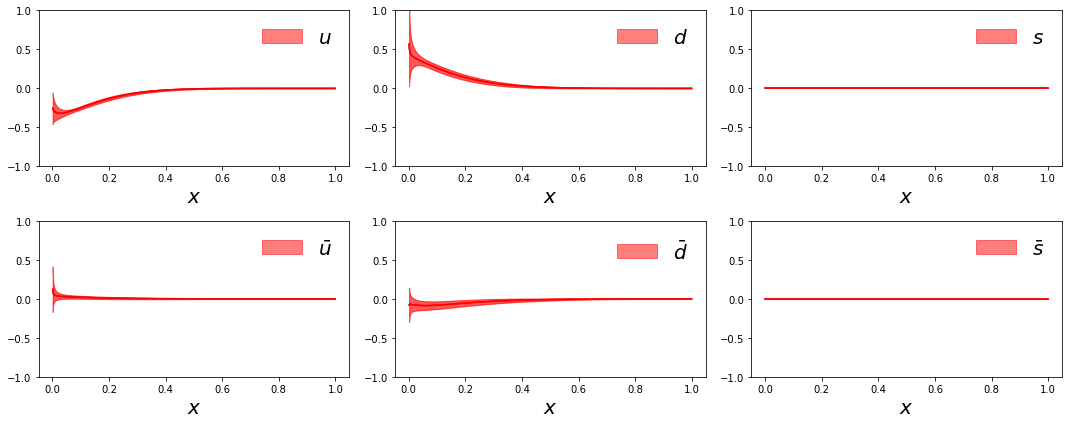

In [11]:
nrows,ncols=2,3
py.figure(figsize=(ncols*5,nrows*3))
def plot(idx,flav,run1,run2):
    ax=py.subplot(nrows,ncols,idx)
    # labels
    if flav==1: label=r'$u$'
    if flav==2: label=r'$\bar{u}$'
    if flav==3: label=r'$d$'
    if flav==4: label=r'$\bar{d}$'
    if flav==5: label=r'$s$'
    if flav==6: label=r'$\bar{s}$'
    # colors
    #if flav==1: color='r'
    #elif flav==3: color='b'
    #elif any([flav==x for x in [2,4,5,6]]): color='g'
    colors=['r','b','g','y','c','m','gray','orange','gold','k']
    # plots
    ax.fill_between(X,(h[run1]['f'][flav]-h[run1]['df'][flav]),(h[run1]['f'][flav]+h[run1]['df'][flav]),color=colors[run1],alpha=0.5,label=label)
    ax.plot(X,h[run1]['f'][flav],color=colors[run1])
    ax.fill_between(X,(h[run2]['f'][flav]-h[run2]['df'][flav]),(h[run2]['f'][flav]+h[run2]['df'][flav]),color=colors[run2],alpha=0.3)
    ax.plot(X,h[run2]['f'][flav],color=colors[run2])
    ax.set_xlabel(r'$x$',size=20)
    ax.set_ylim(-1,1)
    ax.legend(fontsize=20,frameon=False)
    return ax

id1=0
id2=0
ax=plot(1,1,id1,id2)
ax=plot(2,3,id1,id2)
ax=plot(3,5,id1,id2)
ax=plot(4,2,id1,id2)
ax=plot(5,4,id1,id2)
ax=plot(6,6,id1,id2)
py.tight_layout()

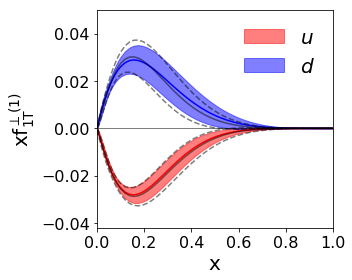

In [14]:
run=0
run2=1
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1)
# plots
ax.fill_between(X,X*(h[run]['f'][1]-h[run]['df'][1]),X*(h[run]['f'][1]+h[run]['df'][1]),color='r',alpha=0.5,label=r'$u$')
ax.plot(X,X*h[run]['f'][1],color='r')
ax.fill_between(X,X*(h[run]['f'][3]-h[run]['df'][3]),X*(h[run]['f'][3]+h[run]['df'][3]),color='b',alpha=0.5,label=r'$d$')
ax.plot(X,X*h[run]['f'][3],color='b')
# another run
ax.plot(X,X*(h[run2]['f'][1]-h[run2]['df'][1]),color='k',alpha=0.5,ls='--')
ax.plot(X,X*(h[run2]['f'][1]+h[run2]['df'][1]),color='k',alpha=0.5,ls='--')
ax.plot(X,X*h[run2]['f'][1],color='k',alpha=0.5)
ax.plot(X,X*(h[run2]['f'][3]-h[run2]['df'][3]),color='k',alpha=0.5,ls='--')
ax.plot(X,X*(h[run2]['f'][3]+h[run2]['df'][3]),color='k',alpha=0.5,ls='--')
ax.plot(X,X*h[run2]['f'][3],color='k',alpha=0.5)
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm xf_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-0.042,0.05)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([-0.04,-0.02,0,0.02,0.04])
ax.legend(fontsize=20,frameon=False)

py.tight_layout()
#py.savefig('%s/xf-runs.png'%path)

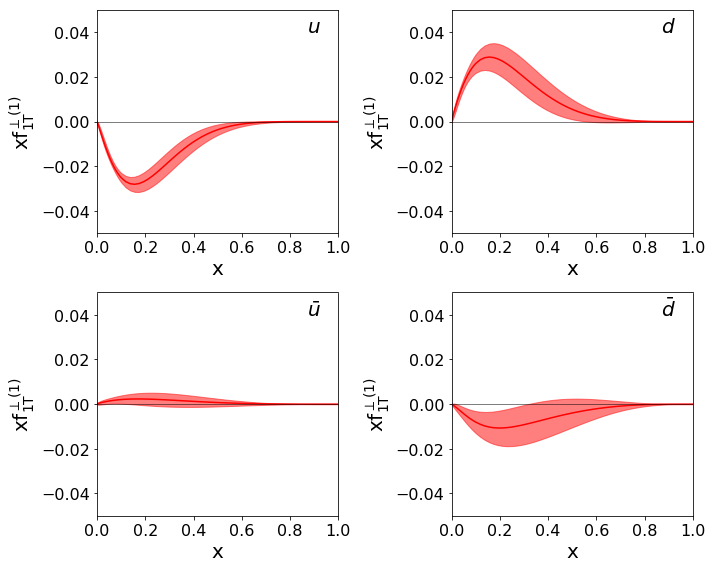

In [15]:
run=0
nrows,ncols=2,2
py.figure(figsize=(ncols*5,nrows*4))

ax=py.subplot(nrows,ncols,1)
ax.fill_between(X,X*(h[run]['f'][1]-h[run]['df'][1]),X*(h[run]['f'][1]+h[run]['df'][1]),color='r',alpha=0.5,label=r'$u$')
ax.plot(X,X*h[run]['f'][1],color='r')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm xf_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-0.05,0.05)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([-0.04,-0.02,0,0.02,0.04])
ax.text(0.9,0.9,r'$u$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

ax=py.subplot(nrows,ncols,2)
ax.fill_between(X,X*(h[run]['f'][3]-h[run]['df'][3]),X*(h[run]['f'][3]+h[run]['df'][3]),color='r',alpha=0.5,label=r'$d$')
ax.plot(X,X*h[run]['f'][3],color='r')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm xf_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-0.05,0.05)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([-0.04,-0.02,0,0.02,0.04])
ax.text(0.9,0.9,r'$d$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

ax=py.subplot(nrows,ncols,3)
ax.fill_between(X,X*(h[run]['f'][2]-h[run]['df'][2]),X*(h[run]['f'][2]+h[run]['df'][2]),color='r',alpha=0.5,label=r'$\bar{u}$')
ax.plot(X,X*h[run]['f'][2],color='r')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm xf_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-0.05,0.05)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([-0.04,-0.02,0,0.02,0.04])
ax.text(0.9,0.9,r'$\bar{u}$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

ax=py.subplot(nrows,ncols,4)
ax.fill_between(X,X*(h[run]['f'][4]-h[run]['df'][4]),X*(h[run]['f'][4]+h[run]['df'][4]),color='r',alpha=0.5,label=r'$\bar{d}$')
ax.plot(X,X*h[run]['f'][4],color='r')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm xf_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-0.05,0.05)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticks([-0.04,-0.02,0,0.02,0.04])
ax.text(0.9,0.9,r'$\bar{d}$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)


py.tight_layout()
py.savefig('%s/xf.png'%path)

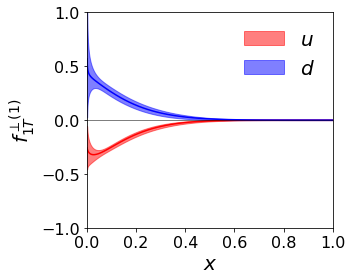

In [12]:
run=0
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*4))
ax=py.subplot(nrows,ncols,1)
# plots
ax.fill_between(X,(h[run]['f'][1]-h[run]['df'][1]),(h[run]['f'][1]+h[run]['df'][1]),color='r',alpha=0.5,label=r'$u$')
ax.plot(X,h[run]['f'][1],color='r')
ax.fill_between(X,(h[run]['f'][3]-h[run]['df'][3]),(h[run]['f'][3]+h[run]['df'][3]),color='b',alpha=0.5,label=r'$d$')
ax.plot(X,h[run]['f'][3],color='b')
ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$f_{1T}^{\perp(1)}$',size=20)
ax.set_xlim(0,1)
ax.set_ylim(-1,1)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.legend(fontsize=20,frameon=False)

py.tight_layout()
py.savefig('%s/f.png'%path)

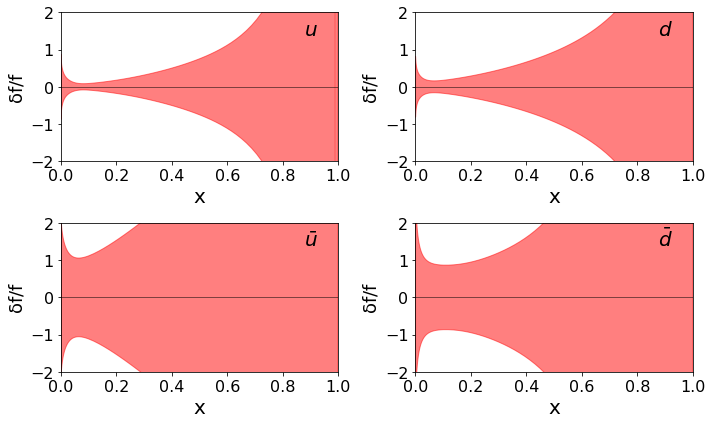

In [13]:
run=1
nrows,ncols=2,2
py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
ax.fill_between(X,h[run]['df'][1]/h[run]['f'][1],-h[run]['df'][1]/h[run]['f'][1],color='r',alpha=0.5,label=r'$u$')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm {\delta}f/f}$',size=18)
ax.axhline(y=0,color='k',lw=0.5)
ax.set_xlim(0,1)
ax.set_ylim(-2,2)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.text(0.9,0.85,r'$u$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)


ax=py.subplot(nrows,ncols,2)
ax.fill_between(X,h[run]['df'][3]/h[run]['f'][3],-h[run]['df'][3]/h[run]['f'][3],color='r',alpha=0.5,label=r'$d$')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm {\delta}f/f$',size=18)
ax.set_xlim(0,1)
ax.set_ylim(-2,2)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.text(0.9,0.85,r'$d$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

ax=py.subplot(nrows,ncols,3)
ax.fill_between(X,h[run]['df'][2]/h[run]['f'][2],-h[run]['df'][2]/h[run]['f'][2],color='r',alpha=0.5,label=r'$\bar{u}$')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm {\delta}f/f$',size=18)
ax.set_xlim(0,1)
ax.set_ylim(-2,2)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.text(0.9,0.85,r'$\bar{u}$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

ax=py.subplot(nrows,ncols,4)
ax.fill_between(X,h[run]['df'][4]/h[run]['f'][4],-h[run]['df'][4]/h[run]['f'][4],color='r',alpha=0.5,label=r'$\bar{d}$')
ax.set_xlabel(r'$\rm x$',size=20)
ax.set_ylabel(r'$\rm {\delta}f/f$',size=18)
ax.set_xlim(0,1)
ax.set_ylim(-2,2)
ax.axhline(y=0,color='k',lw=0.5)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.text(0.9,0.85,r'$\bar{d}$',horizontalalignment='center',transform=ax.transAxes,fontsize=20)
#ax.legend(fontsize=20,frameon=False)

py.tight_layout()
py.savefig('%s/relative-error.png'%path)